# Importation des modules et chargement des fichiers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from collections import Counter
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from numpy import int8
from torch.optim.lr_scheduler import StepLR

!pip install category_encoders --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.0 MB/s eta 0:00:00


In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [ ]:
# Charger les données
print("Chargement des données...")
X_train = pd.read_csv("train_input.csv")
y_train = pd.read_csv("train_output.csv")
X_test = pd.read_csv("test_input.csv")
print("Données chargées avec succès.")

Chargement des données...


<ipython-input-3-1dd1e3cb11fb>:3: DtypeWarning: Columns (16,17,29,30,31,126,128,129,132,133,135,138,371) have mixed types. Specify dtype option on import or set low_memory=False.
  X_train = pd.read_csv("train_input.csv")
<ipython-input-3-1dd1e3cb11fb>:5: DtypeWarning: Columns (16,17,29,30,31,126,128,129,132,133,135,138,371) have mixed types. Specify dtype option on import or set low_memory=False.
  X_test = pd.read_csv("test_input.csv")


Données chargées avec succès.


#Info Data

In [ ]:
print("Dimensions des données d'entraînement :")
print(X_train.shape)
print("Dimensions des données de sortie :")
print(y_train.shape)
print("Dimensions des données de test :")
print(X_test.shape)

Dimensions des données d'entraînement :
(383610, 374)
Dimensions des données de sortie :
(383610, 5)
Dimensions des données de test :
(95852, 374)


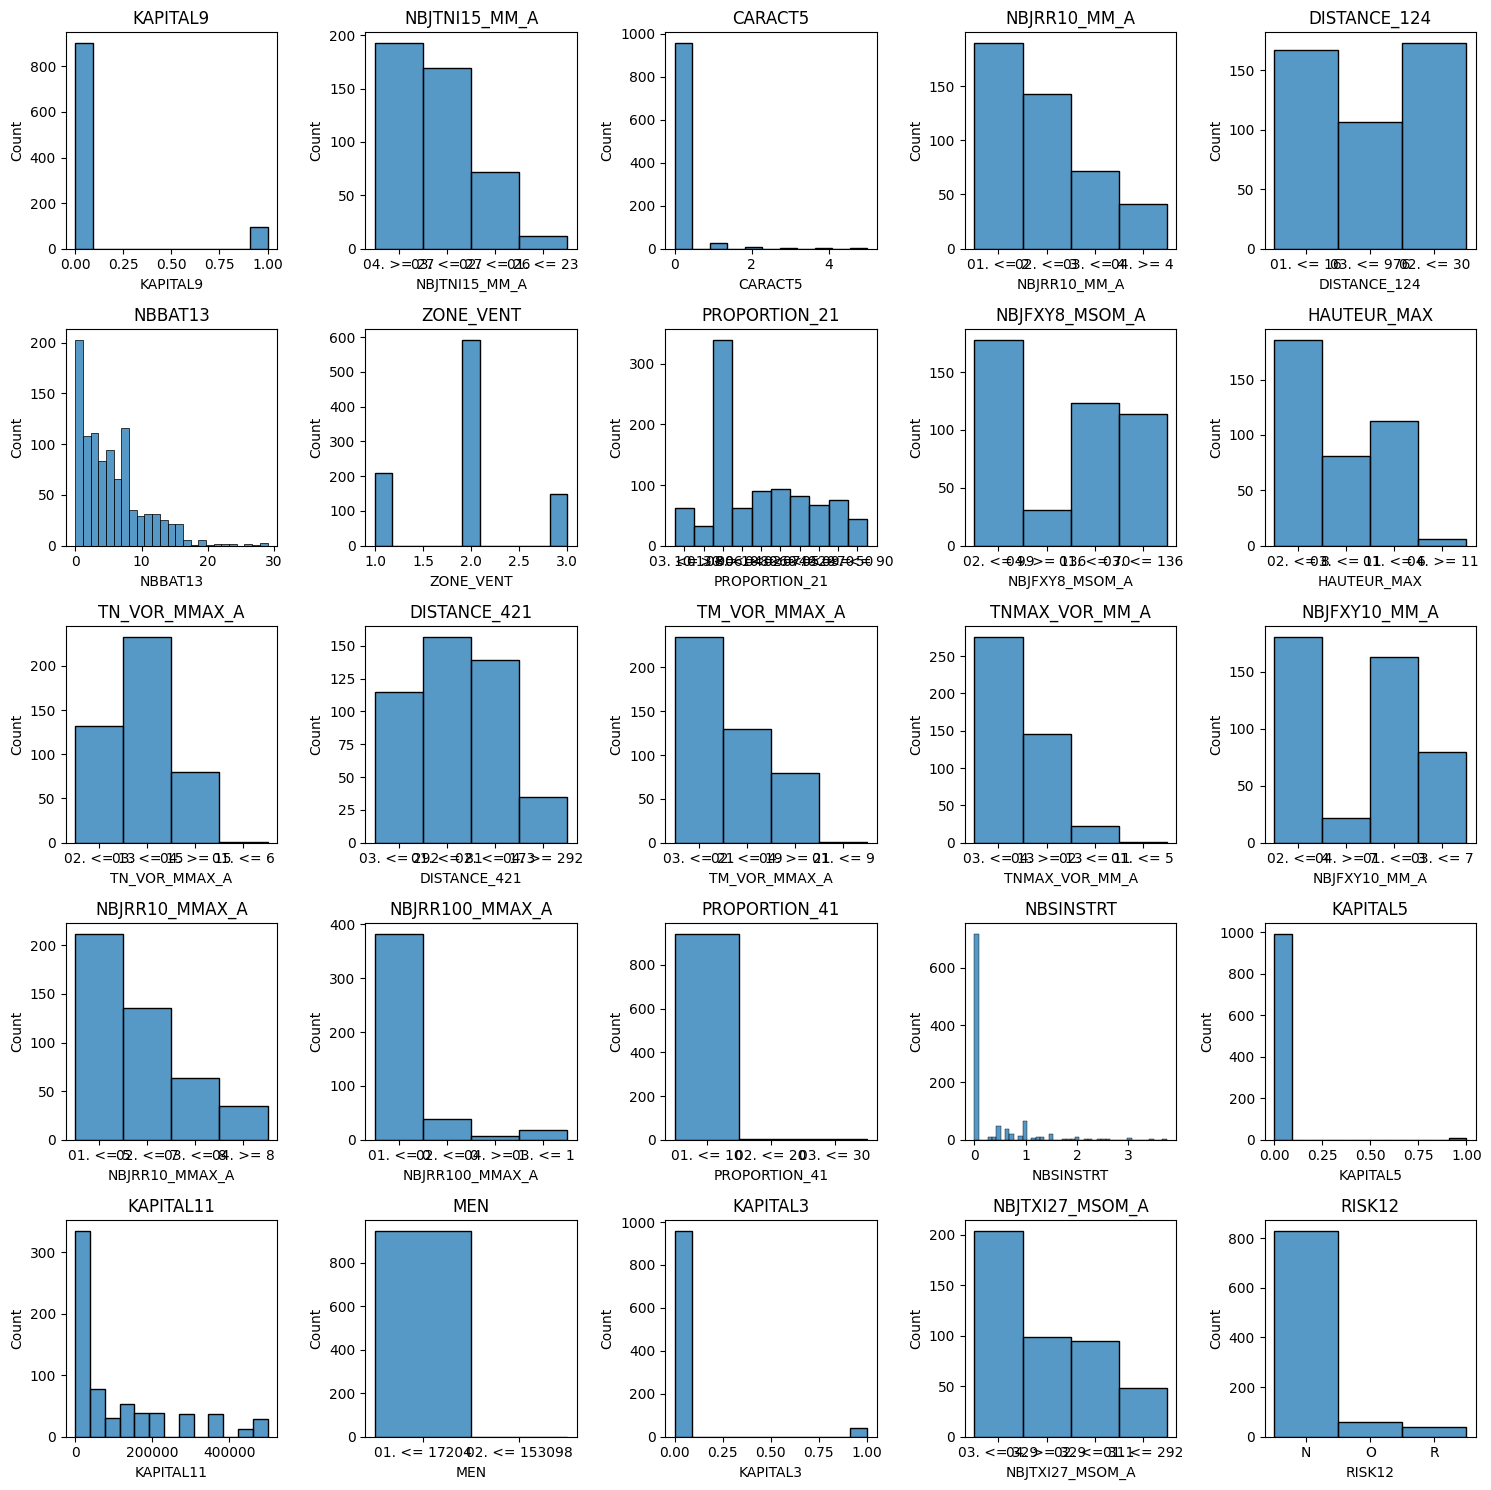

In [ ]:
import seaborn as sns

random_indices = np.random.choice(X_train.shape[0], size=1000, replace=False)
random_cols = np.random.choice(X_train.shape[1], size=25, replace=False)

fig, axes = plt.subplots(5,5, figsize=(15, 15))
ax = axes.flatten()

for i, col in enumerate(X_train.columns[random_cols]):
    sns.histplot(X_train.loc[random_indices, col], ax=ax[i]) # histogram call
    ax[i].set_title(col)
    # remove scientific notation for both axes
    # ax[i].ticklabel_format(style='plain', axis='both')

fig.tight_layout() # change padding
plt.savefig('histograms.png')
plt.show()

# Preprocessing

## Remove ID and assurance columns

In [ ]:
#remove col id and annee assurance
X_train_enc = X_train.drop(['ID', 'ANNEE_ASSURANCE'], axis=1)
X_test_enc = X_test.drop(['ID', 'ANNEE_ASSURANCE'], axis=1)
print("X train shape:",X_train_enc.shape)
print("X test shape:",X_test_enc.shape)
y_train_enc = y_train.drop(['ID'], axis=1)
print("y train shape:",y_train_enc.shape)

X train shape: (383610, 372)
X test shape: (95852, 372)
y train shape: (383610, 4)


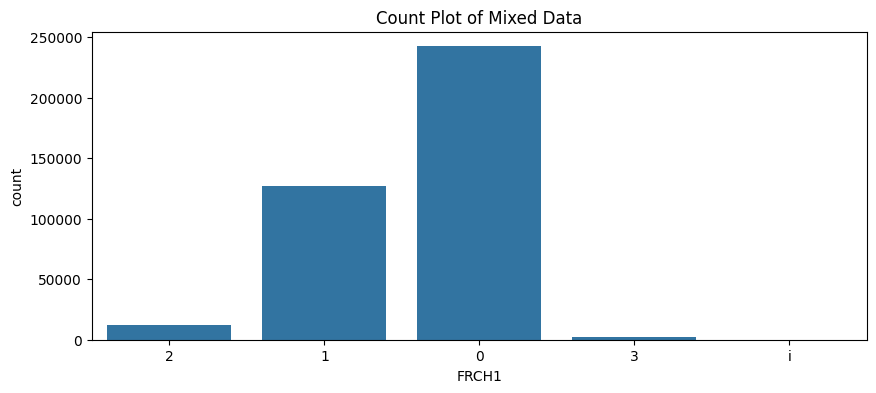

In [ ]:
import seaborn as sns

#X_train_enc['FRCH1'] = X_train_enc['FRCH1'].apply(
#    lambda x: f"num_{x}" if isinstance(x, (int, float)) else f"str_{x}"
#)
#X_train_enc['FRCH2'] = X_train_enc['FRCH2'].apply(
#    lambda x: f"num_{x}" if isinstance(x, (int, float)) else f"str_{x}"
#)


fig, ax = plt.subplots(1,figsize=(10, 4))

sns.countplot(x = X_train_enc.loc[:, 'FRCH1'], ax=ax) # histogram call
ax.set_title("FRCH1")
# remove scientific notation for both axes
# ax[i].ticklabel_format(style='plain', axis='both')

plt.title('Count Plot of Mixed Data')
plt.show()

## Create two columns for mixed data

In [ ]:
#Make "1" become 1
print(f"Before transformation: {X_train_enc.loc[:, 'FRCH1'].value_counts()}")
X_train_enc.loc[:, 'FRCH1'] = X_train_enc.loc[:, 'FRCH1'].apply(lambda x: int(x) if type(x) == str and x.isdigit() else x)
X_test_enc.loc[:, 'FRCH1'] = X_test_enc.loc[:, 'FRCH1'].apply(lambda x: int(x) if type(x) == str and x.isdigit() else x)
print(f"After transformation: {X_train_enc.loc[:, 'FRCH1'].value_counts()}")

print(f"Before transformation: {X_train_enc.loc[:, 'FRCH2'].value_counts()}")
X_train_enc.loc[:, 'FRCH2'] = X_train_enc.loc[:, 'FRCH2'].apply(lambda x: int(x) if type(x) == str and x.isdigit() else x)
X_test_enc.loc[:, 'FRCH2'] = X_test_enc.loc[:, 'FRCH2'].apply(lambda x: int(x) if type(x) == str and x.isdigit() else x)
print(f"After transformation: {X_train_enc.loc[:, 'FRCH2'].value_counts()}")

Before transformation: FRCH1
0    169031
1    102148
0     73268
1     24697
2      9894
3      2185
2      1899
3       424
i        64
Name: count, dtype: int64
After transformation: FRCH1
0    242299
1    126845
2     11793
3      2609
i        64
Name: count, dtype: int64
Before transformation: FRCH2
1    161789
2    123820
A     55578
3     14969
4       651
5       230
Name: count, dtype: int64
After transformation: FRCH2
1    161789
2    123820
A     55578
3     14969
4       651
5       230
Name: count, dtype: int64


## Count number of numeric, mixed and string columns

In [ ]:
numeric_columns = X_train_enc.select_dtypes(include=['number']).columns
print("Number of numerical columns: ",len(numeric_columns))

mixed_columns = ['FRCH1', 'FRCH2']
print("Number of columns with mixte values: ",len(mixed_columns))

string_columns = [item for item in X_train_enc.columns if (item not in numeric_columns and item not in mixed_columns)]
print("Number of string columns:",len(string_columns))

Number of numerical columns:  92
Number of columns with mixte values:  2
Number of string columns: 278


In [ ]:
print("Nan Numeric:",X_train_enc[numeric_columns].isna().sum().sum())
print("Nan String:",X_train_enc[string_columns].isna().sum().sum())
print("Nan Mixed:",X_train_enc[mixed_columns].isna().sum().sum())

Nan Numeric: 1179979
Nan String: 42422569
Nan Mixed: 26573


In [ ]:
print(f"Percentage of NaN data: {X_train_enc.isna().sum().sum() / (X_train_enc.shape[0] * X_train_enc.shape[1]) * 100:.2f} %")

Percentage of NaN data: 30.57 %


## Encode categoric columns

In [ ]:
from category_encoders import CountEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import string
import gc
import re

def str_convert(x):
    return str(x).upper()

def get_class_order(series):
    # print('get_class_order', series)
    # Create a list of tuples with (numeric prefix, full label)
    label_pairs = [(int(re.findall(r'\d+', label)[0]), label) for label in series.index]

    # Sort the list based on the numeric prefix
    sorted_labels = sorted(label_pairs, key=lambda x: x[0])

    # Return only the full labels in sorted order
    return [label for _, label in sorted_labels]

def get_numeric_order(series):
    # print('get_numeric_order', series)
    # Create a list of tuples with (numeric prefix, full label)
    label_pairs = [(int(label[:2]), label) if len(label) > 1 else (int(label), label) for label in series.index]

    # Sort the list based on the numeric prefix
    sorted_labels = sorted(label_pairs, key=lambda x: x[0])

    # Return only the full labels in sorted order
    return [label for _, label in sorted_labels]

def sort_surface_series(series):
    # print('surface_series', series)
    # Replace '7000+' with '7500' (placeholder) and convert to int
    series = series.rename(lambda x: '7500' if x == '7000+' else x)
    series.index = series.index.astype(int)

    # Sort the series
    return series.index.sort_values().tolist()

def check_inequality_pattern(series):
    # print('check_inequality_pattern', series)
    # Check if classes are in the form "01. <= 0" (column NBJRR100_MMAX_A), "04. >= 25" (column RRAB_VOR_MM_A), etc.
    pattern = r'^\d+\.\s*([<>]=?|=)'
    return series.index.str.match(pattern).any()

In [ ]:
from tqdm import tqdm

progress_bar = tqdm(total=X_train.shape[1])

# Iterate over X_train_enc
for i, col in enumerate(X_train_enc.columns):
    # Select categoric columns
    if X_train_enc[col].dtype == 'object' or X_train_enc[col].dtype.name == 'category':
        # print("{:4d}: {}".format(i, col))

        # Count number of "classes" per categoric column
        vals = X_train_enc[col].value_counts()

        # If classes are letters (e.g. 'N', 'O', 'R'), encode these letters as numbers
        if any(val in vals for val in string.ascii_letters):
            if col in ['FRCH1', 'FRCH2']: # This column has mixed types (str and int) -> skip to process later
                continue

            order = vals.index.sort_values().tolist()

            # Replace 'N' (non) -> 0, 'O' (oui) -> 1, 'R' (?) -> 2
            encoder = OrdinalEncoder(cols=[col], mapping=[{'col': col, 'mapping': {cat: i for i, cat in enumerate(order)}}])

            # Apply transformation
            X_train_enc[col] = encoder.fit_transform(X_train_enc[col]).astype(int)
            X_test_enc[col] = encoder.transform(X_test_enc[col]).astype(int)

        # Select columns where there is an order (e.g. CARACT4 is an order of area, ACTIVIT2 is an order of activities -> ACT1, ACT2, etc.)
        elif col in ['ACTIVIT2', 'VOCATION', 'INDEM2', 'AN_EXERC', 'CARACT4', 'COEFASS'] or 'TAILLE' in col or \
            'SURFACE' in col or 'DISTANCE' in col or check_inequality_pattern(vals):
            if col == 'CARACT4':
                # Use OrdinalEncoder for ordinal data
                order = ['absence de surface', 'Surface de moins d', 'Surface entre 501',
                        'Surface entre 1001', 'Surface entre 1501', 'Surface de plus de']
            elif 'SURFACE' in col:
                order = sort_surface_series(vals)
            elif col in ['ACTIVIT2', 'VOCATION', 'INDEM2', 'AN_EXERC']:
                order = get_class_order(vals)
            else:
                order = get_numeric_order(vals)

            # Map classes to an ordered sequence (e.g. CARACT4 will contain 0 for "absence de surface", 1 for "Surface de moins d', etc.")
            mapping = {cat: i for i, cat in enumerate(order)}

            # Apply transformations
            X_train_enc[col] = X_train_enc[col].map(mapping)
            X_test_enc[col] = X_test_enc[col].map(mapping)

    progress_bar.update(1)

 99%|█████████▊| 369/374 [00:18<00:00, 15.80it/s]

In [ ]:
#Fix mixed columns by splitting them in 2
# label_encoder = LabelEncoder()

# new_columns = []
# new_columns_test = []
for col in mixed_columns:
    # # extracts string values from the column, setting non-string values to None.
    # str_col = X_train_enc[col].apply(lambda x: x if isinstance(x, str) else None)
    # str_col_test = X_test_enc[col].apply(lambda x: x if isinstance(x, str) else None)

    # # extracts int, float values from the column, setting non-matches to None.
    # num_col = X_train_enc[col].apply(lambda x: x if isinstance(x, (int, float)) else None)
    # num_col_test = X_test_enc[col].apply(lambda x: x if isinstance(x, (int, float)) else None)

    # # replace None with "missing"
    # str_col = str_col.fillna("missing")
    # str_col_test = str_col_test.fillna("missing")

    # # converts the string values in str_col and str_col_test to numerical labels
    # str_col = label_encoder.fit_transform(str_col)
    # str_col_test = label_encoder.transform(str_col_test)

    num_col = X_train_enc.loc[:, col].apply(lambda x: x if type(x) == int else -1)
    num_col_test = X_test_enc.loc[:, col].apply(lambda x: x if type(x) == int else -1)

    # num_col = X_train_enc[col].apply(lambda x: int(x) if x != else None)
    # num_col_test = X_test_enc[col]

    # Fill missing values in num_col and num_col_test with the mean of the numeric values.
    num_col = num_col.fillna(num_col.mean())
    num_col_test = num_col_test.fillna(num_col.mean())

    # normalize numeric values in num_col and num_col_test by subtracting the mean and dividing by the standard deviation
    num_col = (num_col - num_col.mean())/num_col.std()
    num_col_test = (num_col_test - num_col.mean())/num_col.std()

    num_col[X_train_enc.loc[:, col].apply(lambda x: type(x) == str)] = -1
    num_col_test[X_test_enc.loc[:, col].apply(lambda x: type(x) == str)] = -1
    X_train_enc.loc[:, col] = num_col
    X_test_enc.loc[:, col] = num_col_test

    # # append "newly created columns" to the list of new columns
    # new_columns.append(pd.DataFrame({
    #     col + '_str': str_col,
    #     col + '_num': num_col
    # }))
    # new_columns_test.append(pd.DataFrame({
    #     col + '_str': str_col_test,
    #     col + '_num': num_col_test
    # }))

# add new columns to the DataFrame
# X_train_enc = pd.concat([X_train_enc.drop(columns=mixed_columns)] + new_columns, axis=1)
# X_test_enc = pd.concat([X_test_enc.drop(columns=mixed_columns)] + new_columns_test, axis=1)

## Checking shapes

In [ ]:
print("Shape of data after adding new columns")
print(X_train_enc.shape)
print(X_test_enc.shape)

print("Shape of original data")
print(X_train.shape)

Shape of data after adding new columns
(383610, 372)
(95852, 372)
Shape of original data
(383610, 374)


In [ ]:
numeric_columns = [col for col in X_train_enc.select_dtypes(include=['number']).columns if col not in ['FRCH1', 'FRCH2']]
print("Number of numerical columns: ",len(numeric_columns))

mixed_columns = ['FRCH1', 'FRCH2']
print("Number of columns with mixte values: ",len(mixed_columns))

string_columns = [item for item in X_train_enc.columns if (item not in numeric_columns and item not in mixed_columns)]
print("Number of string columns:",len(string_columns))

Number of numerical columns:  363
Number of columns with mixte values:  2
Number of string columns: 7


## Normalize numeric data

In [ ]:
#Normalization + filling NaN for numeric data
X_train_mean = X_train_enc[numeric_columns].mean()
X_train_std = X_train_enc[numeric_columns].std()

X_train_enc[numeric_columns] = X_train_enc[numeric_columns].fillna(X_train_mean)
X_train_enc[numeric_columns] = (X_train_enc[numeric_columns] - X_train_mean)/X_train_std
X_test_enc[numeric_columns] = X_test_enc[numeric_columns].fillna(X_train_mean)
X_test_enc[numeric_columns] = (X_test_enc[numeric_columns] - X_train_mean)/X_train_std

y_train_mean = y_train_enc.mean()
y_train_std = y_train_enc.std()
y_train_enc = (y_train_enc-y_train_mean)/y_train_std

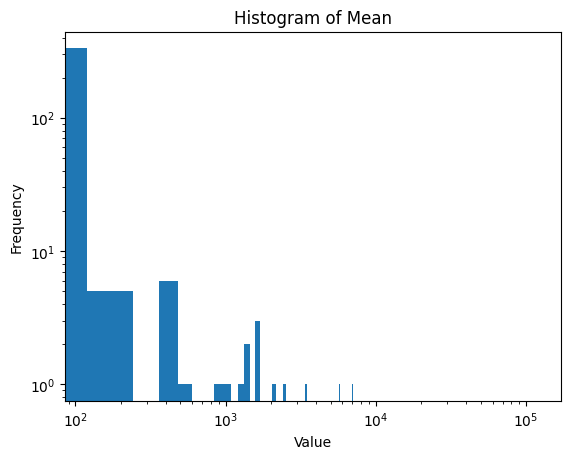

In [ ]:
X_train_mean.plot(kind='hist', log=True, bins=1000)
plt.semilogx()
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Mean')
plt.savefig('hist_mean.png')
plt.show()

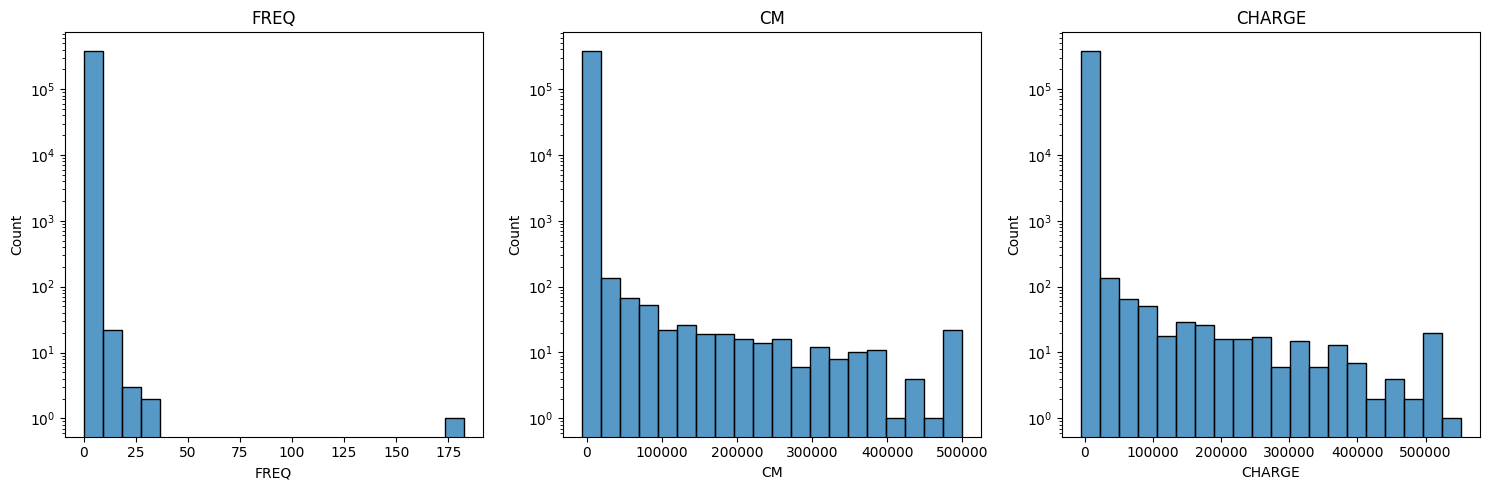

In [ ]:
# prompt: How to plot the histograms of the columns in y, except for the ID and annee assurance columns where each column is a subplot

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_train_enc is your preprocessed DataFrame
# and y_train_enc is your target variable DataFrame

# Exclude 'ID' and 'ANNEE_ASSURANCE' columns if present in y_train_enc
columns_to_plot = [col for col in y_train.columns if col not in ['ID', 'ANNEE_ASSURANCE']]

num_plots = len(columns_to_plot)
num_cols = 3  # Number of columns in the subplot grid
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration


for i, col in enumerate(columns_to_plot):
    sns.histplot(y_train[col], ax=axes[i], kde=False, log=True)  # histogram call
    axes[i].set_title(col)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.savefig('histograms_y_train.png')
plt.show()


In [ ]:
# Calculate the correlation matrix
correlation_matrix = y_train_enc[columns_to_plot].corr()

# Print or visualize the correlation matrix
print(correlation_matrix)

            FREQ        CM    CHARGE
FREQ    1.000000  0.139367  0.141063
CM      0.139367  1.000000  0.995048
CHARGE  0.141063  0.995048  1.000000


## One hot encoding for string columns

In [ ]:
print(string_columns)

['TYPBAT1', 'DEROG12', 'DEROG13', 'DEROG14', 'DEROG16', 'EQUIPEMENT5', 'ESPINSEE']


In [ ]:
#One hot encoding for string columns
X_train_enc = pd.get_dummies(X_train_enc, columns =  string_columns, prefix = string_columns, dummy_na=False,dtype=int8)
X_test_enc = pd.get_dummies(X_test_enc, columns =  string_columns, prefix = string_columns, dummy_na=False,dtype=int8)

missing_cols = list(set(X_train_enc.columns) - set(X_test_enc.columns))

# Align columns: Add missing columns to X_test, and remove extra ones
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)
X_test_enc[missing_cols] = X_test_enc[missing_cols].astype('int8')

In [ ]:
print("Shape of data after one hot")
print(X_train_enc.shape)
print(X_test_enc.shape)

Shape of data after one hot
(383610, 397)
(95852, 397)


In [ ]:
X_train_enc['FRCH1'] = pd.to_numeric(X_train_enc['FRCH1'])
X_train_enc['FRCH2'] = pd.to_numeric(X_train_enc['FRCH2'])
X_test_enc['FRCH1'] = pd.to_numeric(X_test_enc['FRCH1'])
X_test_enc['FRCH2'] = pd.to_numeric(X_test_enc['FRCH2'])

In [ ]:
print("Count dtypes")
print(X_train_enc.dtypes.value_counts())
print(X_test_enc.dtypes.value_counts())

Count dtypes
float64    365
int8        32
Name: count, dtype: int64
float64    365
int8        32
Name: count, dtype: int64


In [ ]:
print("Show nan columns after applying transformations")
nancols = X_train_enc.columns[np.where(X_train_enc.isna().all(axis=0))].tolist()
print('In columns', nancols, 'all elements are NaN. Dropping...')
X_train_enc.drop(columns=nancols, inplace=True)
X_test_enc.drop(columns=nancols, inplace=True)

Show nan columns after applying transformations
In columns ['SURFACE4', 'SURFACE6', 'DISTANCE_244', 'IND_Y1_Y2', 'IND_INC'] all elements are NaN. Dropping...


In [ ]:
print("Nan Elements in X_train_enc:",X_train_enc.isna().sum().sum())

Nan Elements in X_train_enc: 0


## Pandas to tensor

In [ ]:
train_with_all_data = False

if train_with_all_data:
    nbr_train = X_train.shape[0]
else:
    nbr_train = 50000
    indices = np.random.choice(X_train.shape[0], nbr_train, replace=False)

X_train_tensor = torch.tensor(X_train_enc.values[indices], dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_enc.values[indices], dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_train_enc.values[~indices], dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_train_enc.values[~indices], dtype=torch.float32).to(device)

y_train_original = torch.tensor(y_train_enc[["FREQ", "CM", "ANNEE_ASSURANCE", "CHARGE"]].values[indices], dtype=torch.float32).to(device)
y_val_original = torch.tensor(y_train_enc[["FREQ", "CM", "ANNEE_ASSURANCE", "CHARGE"]].values[~indices], dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test_enc.values, dtype=torch.float32).to(device)

In [ ]:
def rmse_loss(outputs, labels):
    mse_loss = torch.nn.functional.mse_loss(outputs, labels)
    return torch.sqrt(mse_loss)

In [ ]:
zero_rows_index = torch.nonzero(y_train_original[:, 1] == 0, as_tuple=True)[0]
non_zero_rows_index = torch.nonzero(y_train_original[:, 1] != 0, as_tuple=True)[0]

# Modèle MLP

In [ ]:
# 2 models one for frequency one for the other
# !!! Don't predict charge for the one with 0 frequency
class Net(nn.Module):
  def __init__(self,n):
    super().__init__()
    self.layer1 = nn.Linear(n,n//4, bias=True)
    self.layer2 = nn.Linear(n//4,n//16, bias=True)
    self.layer3 = nn.Linear(n//16, 1, bias=True)
    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.layer1(x)
    x = self.activation(x)
    x = self.layer2(x)
    x = self.activation(x)
    x = self.layer3(x)
    x = self.activation(x)
    return x

  def train_model(self, train_loader, val_loader, loss_function, optimizer, scheduler, num_epochs):
        train_loss_array = []
        val_loss_array = []
        for epoch in range(num_epochs):
            self.train()

            total_loss_train = 0.0
            total_loss_val = 0.0

            for features, labels in train_loader:
                optimizer.zero_grad()

                outputs = self.forward(features).squeeze()

                loss = loss_function(outputs, labels.float())

                loss.backward()

                optimizer.step()

                total_loss_train += loss.item()

            scheduler.step()


            self.eval()
            for features, labels in val_loader:
                outputs = self.forward(features).squeeze()
                loss = loss_function(outputs, labels.float())
                total_loss_val += loss.item()

            avg_loss_train = total_loss_train / len(train_loader)
            print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss_train:.4f}")
            train_loss_array.append(avg_loss_train)

            avg_loss_val = total_loss_val / len(val_loader)
            print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss_val:.4f}")
            val_loss_array.append(avg_loss_val)

        return train_loss_array, val_loss_array

In [ ]:
#Use decreasing step size
num_epochs = 50
learning_rate = 0.0001
batchsize = 1024

model_freq = Net(n= X_train_tensor.shape[1]).to(device)

optimizer = torch.optim.Adam(model_freq.parameters(),lr = learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.3)

dataset_train = TensorDataset(X_train_tensor, y_train_tensor[:,0])
dataset_val = TensorDataset(X_val_tensor, y_val_tensor[:,0])
train_loader = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batchsize, shuffle=True)

train_loss_array, val_loss_array = model_freq.train_model(train_loader, val_loader, rmse_loss, optimizer, scheduler, num_epochs)

Epoch 1/50, Average Loss: 0.6545
Epoch 1/50, Average Loss: 0.4828
Epoch 2/50, Average Loss: 0.6580
Epoch 2/50, Average Loss: 0.4885
Epoch 3/50, Average Loss: 0.6583
Epoch 3/50, Average Loss: 0.4872
Epoch 4/50, Average Loss: 0.6338
Epoch 4/50, Average Loss: 0.4884
Epoch 5/50, Average Loss: 0.6358
Epoch 5/50, Average Loss: 0.4906
Epoch 6/50, Average Loss: 0.6288
Epoch 6/50, Average Loss: 0.4860
Epoch 7/50, Average Loss: 0.6480
Epoch 7/50, Average Loss: 0.4893
Epoch 8/50, Average Loss: 0.6374
Epoch 8/50, Average Loss: 0.4898
Epoch 9/50, Average Loss: 0.6561
Epoch 9/50, Average Loss: 0.4891
Epoch 10/50, Average Loss: 0.6431
Epoch 10/50, Average Loss: 0.4854
Epoch 11/50, Average Loss: 0.6492
Epoch 11/50, Average Loss: 0.4878
Epoch 12/50, Average Loss: 0.6490
Epoch 12/50, Average Loss: 0.4856
Epoch 13/50, Average Loss: 0.6451
Epoch 13/50, Average Loss: 0.4872
Epoch 14/50, Average Loss: 0.6423
Epoch 14/50, Average Loss: 0.4855
Epoch 15/50, Average Loss: 0.6432
Epoch 15/50, Average Loss: 0.489

In [ ]:
plt.plot(range(1,num_epochs+1),train_loss_array,label='Train loss')
plt.plot(range(1,num_epochs+1),val_loss_array, label='Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

NameError: name 'num_epochs' is not defined

# Linear Reg

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV

In [ ]:


#FREQ predict

alpha = 1.0

#linreg_freq = LinearRegression()
linreg_freq = Lasso(alpha = alpha)
#linreg_freq = Ridge(alpha= alpha)

linreg_freq.fit(X_train_tensor, y_train_tensor[:,0])

pred_train_freq = linreg_freq.predict(X_train_tensor)

if not train_with_all_data:
    pred_val_freq = linreg_freq.predict(X_val_tensor)

y_train_pred_rescaled = pred_train_freq * y_train_std['FREQ'] + y_train_mean['FREQ'] # y_pred * (original_max - original_min) + original_min

if not train_with_all_data:
    y_val_pred_rescaled = pred_val_freq * y_train_std['FREQ'] + y_train_mean['FREQ']

print("Train error:", rmse_loss(torch.tensor(y_train['FREQ'].values[:nbr_train], dtype = torch.float32),  torch.tensor(y_train_pred_rescaled, dtype=torch.float32)))

if not train_with_all_data:
    print("Val error:", rmse_loss(torch.tensor(y_train['FREQ'].values[nbr_train:], dtype = torch.float32),  torch.tensor(y_val_pred_rescaled, dtype=torch.float32)))

Train error: tensor(0.3571)


In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Performance Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

    return {'model': model_name, 'r2': r2, 'rmse': rmse, 'mae': mae}
# List to store results
results = []
best_models = {}

In [ ]:
print("\n=== Linear Regression ===")
lr_model = LinearRegression()
lr_model.fit(X_train_tensor.cpu(), y_train_tensor[:,1].cpu())
lr_pred = lr_model.predict(X_val_tensor.cpu())
results.append(evaluate_model(y_val_tensor[:,2].cpu(), lr_pred, "Linear Regression"))

print("\n=== Linear Regression ===")
lr_model_cm = LinearRegression()
lr_model_cm.fit(X_train_tensor.cpu(), y_train_tensor[:,2].cpu())
lr_pred_cm = lr_model_cm.predict(X_val_tensor.cpu())
results.append(evaluate_model(y_val_tensor[:,2].cpu(), lr_pred_cm, "Linear Regression CM"))

In [ ]:
print("\n=== Ridge Regression Hyperparameter Tuning ===")
ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr']
}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='r2', n_jobs=-1, verbose=10)
ridge_grid.fit(X_train_tensor.cpu(), y_train_tensor[:,:2].cpu())
print(f"Best parameters: {ridge_grid.best_params_}")
ridge_pred = ridge_grid.predict(X_val_tensor.cpu())
results.append(evaluate_model(y_val_tensor[:,:2].cpu(), ridge_pred, "Ridge Regression (Tuned)"))
best_models['Ridge_FREQ'] = ridge_grid.best_estimator_

# ridge_grid_cm = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='r2', n_jobs=-1, verbose=10)
# ridge_grid_cm.fit(X_train_tensor.cpu(), y_train_tensor[:,1].cpu())
# print(f"Best parameters: {ridge_grid_cm.best_params_}")
# ridge_pred_cm = ridge_grid_cm.predict(X_val_tensor.cpu())
# results.append(evaluate_model(y_val_tensor[:,1].cpu(), ridge_pred_cm, "Ridge Regression (Tuned)"))
# best_models['Ridge_CM'] = ridge_grid_cm.best_estimator_


=== Ridge Regression Hyperparameter Tuning ===
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'alpha': 100.0, 'solver': 'svd'}

Ridge Regression (Tuned) Performance Metrics:
R² Score: -0.0858
RMSE: 0.78
MAE: 0.14


In [ ]:
results

[{'model': 'Ridge Regression (Tuned)',
  'r2': -0.16240961716606717,
  'rmse': np.float64(0.6828181834660878),
  'mae': 0.19025092329421817},
 {'model': 'Ridge Regression (Tuned)',
  'r2': -0.009134160065104702,
  'rmse': np.float64(0.8667477371023062),
  'mae': 0.09128661878102091}]

In [ ]:
#CM predict

alpha = 1.0

#linreg_cm = LinearRegression()
linreg_cm = Lasso(alpha = alpha)
#linreg_cm = Ridge(alpha = alpha)

linreg_cm.fit(X_train_tensor, y_train_tensor[:,1])

pred_train_cm = linreg_cm.predict(X_train_tensor)

if not train_with_all_data:
    pred_val_cm = linreg_cm.predict(X_val_tensor)

y_train_pred_rescaled_cm = pred_train_cm * y_train_std['CM'] + y_train_mean['CM']

if not train_with_all_data:
    y_val_pred_rescaled_cm = pred_val_cm * y_train_std['CM'] + y_train_mean['CM']

print("Train error:", rmse_loss(torch.tensor(y_train['CM'].values[:nbr_train], dtype = torch.float32),  torch.tensor(y_train_pred_rescaled_cm, dtype=torch.float32)))

if not train_with_all_data:
    print("Val error:", rmse_loss(torch.tensor(y_train['CM'].values[nbr_train:], dtype = torch.float32),  torch.tensor(y_val_pred_rescaled_cm, dtype=torch.float32)))

Train error: tensor(6699.9590)


In [ ]:
# Charge
y_train_pred = y_train_pred_rescaled * y_train_pred_rescaled_cm * y_train_enc['ANNEE_ASSURANCE'].values[:nbr_train]

if not train_with_all_data:
    y_val_pred = y_val_pred_rescaled * y_val_pred_rescaled_cm * y_train_enc['ANNEE_ASSURANCE'].values[nbr_train:]

rmse = rmse_loss(torch.tensor(y_train_enc['CHARGE'].values[:nbr_train]), torch.tensor(y_train_pred))
print(f"RMSE total sur l'ensemble d'entraînement : {rmse:.2f}")


if not train_with_all_data:
  rmse = rmse_loss(torch.tensor(y_train_enc['CHARGE'].values[nbr_train:]), torch.tensor(y_val_pred))
  print(f"RMSE total sur l'ensemble de validation : {rmse:.2f}")

RMSE total sur l'ensemble d'entraînement : 2.48


##Test

In [ ]:
linreg_freq.predict(X_test_tensor.cpu())

array([[ 0.03785301, -0.18823344],
       [-0.06942028, -0.07215239],
       [ 0.08348204,  0.00498487],
       ...,
       [-0.37400908, -0.03063072],
       [ 0.02151269, -0.01913396],
       [ 0.31344853,  0.1113989 ]])

In [ ]:
# Prédire 'FREQ' sur l'ensemble de test
# linreg_freq = lr_model
# linreg_cm = lr_model_cm
linreg_freq = best_models['Ridge_FREQ']
# linreg_cm = best_models['Ridge_CM']

y_test_pred = linreg_freq.predict(X_test_tensor.cpu())
y_test_pred_freq = y_test_pred[:,0]
y_test_pred_cm = y_test_pred[:,1]
# y_test_pred_freq = linreg_freq.predict(X_test_tensor.cpu())
y_test_pred_rescaled = y_test_pred_freq * y_train_std['FREQ'] + y_train_mean['FREQ'] # y_pred * (original_max - original_min) + original_min

# Prédire 'CM' sur l'ensemble de test
# y_test_pred_cm = linreg_cm.predict(X_test_tensor.cpu())
y_test_pred_rescaled_cm = y_test_pred_cm * y_train_std['CM'] + y_train_mean['CM']

# Prédire assurance sur l'ensemble de test
y_test_pred = y_test_pred_rescaled * y_test_pred_rescaled_cm * X_test['ANNEE_ASSURANCE'].values

In [ ]:
y_test_pred_df = pd.DataFrame(data=np.column_stack([y_test_pred_freq, y_test_pred_cm, X_test['ANNEE_ASSURANCE'].values, y_test_pred]),
                              columns=['FREQ', 'CM', 'ANNEE_ASSURANCE', 'CHARGE'])
y_test_pred_df['ID'] = X_test['ID'].tolist() # index pred with X_test index values
y_test_pred_df = y_test_pred_df[['ID', 'FREQ', 'CM', 'ANNEE_ASSURANCE', 'CHARGE']]
y_test_pred_df

,ID,FREQ,CM,ANNEE_ASSURANCE,CHARGE
0,383611,0.037853,-0.188233,0.813699,-22.793602
1,383612,-0.069420,-0.072152,1.000000,3.713077
2,383613,0.083482,0.004985,0.586301,5.350569
3,383614,-0.021307,0.072373,1.000000,3.231893
4,383615,-0.146961,0.219423,0.753425,-49.845605
...,...,...,...,...,...
95847,479458,0.377299,0.230130,0.005479,1.390801
95848,479459,-0.161999,-0.110681,1.000000,25.381641
95849,479460,-0.374009,-0.030631,0.427397,1.175229
95850,479461,0.021513,-0.019134,1.000000,1.093805


In [ ]:
# save data
y_test_pred_df.to_csv('test_output.csv', index=False)

In [ ]:
df2 = pd.read_csv('test_output (2).csv')

# Neural Networks

Using Poisson and Gamma Distributions

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

n_features = X_train_tensor.shape[1]

freq_model = Sequential([
    Dense(64, activation='relu', input_shape=(n_features,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='exponential')
])

freq_model.compile(optimizer='adam', loss='poisson')

In [ ]:
import tensorflow as tf

def gamma_loss(y_true, my_dist):
    print(y_true, my_dist)
    dist_mean = my_dist.mean()
    dist_stddev = my_dist.stddev()
    alpha = (dist_mean / dist_stddev)**2
    beta = dist_mean / dist_stddev**2
    gamma_distr = tf.distributions.Gamma(concentration=alpha, rate=beta)
    return -tf.reduce_mean(gamma_distr.log_prob(y_true))

avg_cost_model = Sequential([
    Dense(64, activation='relu', input_shape=(n_features,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='exponential')
])

avg_cost_model.compile(optimizer='adam', loss=gamma_loss)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import random

# Assuming X_train_kf is a list of indices
indices = list(range(len([X_train_tensor])))

# Calculate the split point
split_point = int(0.8 * len(indices))

# Shuffle the indices randomly
random.shuffle(indices)

# Split the indices into 80% and 20%
train_index = indices[:split_point]
val_index = indices[split_point:]

print("Number of training samples:", len(train_index))
print("Number of validation samples:", len(val_index))

X_train_kf, X_val_kf = X_train_tensor[train_index], X_train_tensor[val_index]
y_freq_train_kf, y_freq_val_kf = y_train_tensor[train_index,0], y_train_tensor[val_index,0]
y_cost_train_kf, y_cost_val_kf = y_train_tensor[train_index,0], y_train_tensor[val_index,0]

freq_model.fit(X_train_kf.cpu(), y_freq_train_kf.cpu(), validation_data=(X_val_kf.cpu(), y_freq_val_kf.cpu()), epochs=40, batch_size=32)
freq_pred = freq_model.predict(X_val_kf.cpu())

avg_cost_model.fit(X_train_kf.cpu(), y_cost_train_kf.cpu(), validation_data=(X_val_kf.cpu(), y_cost_val_kf.cpu()), epochs=40, batch_size=32)
cost_pred = avg_cost_model.predict(X_val_kf.cpu())

annee_val_kf = y_train_tensor[val_index,2] # ANNEE_ASSURANCE
charge_pred = freq_pred * cost_pred * annee_val_kf

y_charge_val = y_train_tensor[val_index,3]

rmse = np.sqrt(mean_squared_error(y_charge_val, charge_pred))
print(f"Fold RMSE: {rmse}")

In [ ]:
print(f"Freq val pred sum: {freq_pred.sum()}")

# Entraînement des modèles originaux (RF + GB)

In [ ]:
# Entraîner les modèles
print("Entraînement des modèles")

# Modèle pour prédire 'FREQ'
rf_freq = RandomForestRegressor(random_state=42, max_depth=10, n_estimators=100, verbose=10)
rf_freq.fit(X_train_tensor, y_train_tensor[:,0])
print("Modèle pour 'FREQ' entraîné avec succès.")


In [ ]:
# Prédire 'FREQ' sur l'ensemble d'entraînement
y_train_pred_freq = rf_freq.predict(X_train_tensor)

In [ ]:
# Modèle pour prédire 'CM'
gb_cm = GradientBoostingRegressor(random_state=42, verbose=10)
gb_cm.fit(X_train_tensor, y_train_tensor[:,1])
print("Modèle pour 'CM' entraîné avec succès.")

## Predict and calculate errors on the train set

In [ ]:
# Prédire 'CM' sur l'ensemble d'entraînement
y_train_pred_cm = gb_cm.predict(X_train_tensor)

In [ ]:
y_train_pred_rescaled = y_train_pred_freq * y_train_std['FREQ'] + y_train_mean['FREQ'] # y_pred * (original_max - original_min) + original_min
print(y_train_pred_rescaled)

In [ ]:
# Calculer le RMSE sur l'ensemble d'entraînement
rmse = np.sqrt(mean_squared_error(y_train['FREQ'].values[:nbr_train], y_train_pred_rescaled))
# rmse = np.sqrt(mean_squared_error(y_train['FREQ'].values[:nbr_train], y_train_pred_freq))
print(f"RMSE sur l'ensemble d'entraînement pour la 'FREQ' : {rmse:.2f}")

In [ ]:
y_train_pred_rescaled_cm = y_train_pred_cm * y_train_std['CM'] + y_train_mean['CM']
print(y_train_pred_rescaled_cm)

In [ ]:
# Calculer le RMSE sur l'ensemble d'entraînement
rmse = np.sqrt(mean_squared_error(y_train['CM'].values[:nbr_train], y_train_pred_rescaled_cm))
# rmse = np.sqrt(mean_squared_error(y_train['CM'].values[:nbr_train], y_train_pred_cm))
print(f"RMSE sur l'ensemble d'entraînement pour le 'CM' : {rmse:.2f}")

In [ ]:
# Calculer la prédiction combinée pour 'CHARGE'
y_train_pred = y_train_pred_rescaled * y_train_pred_rescaled_cm * y_train_enc['ANNEE_ASSURANCE'].values[:nbr_train]
# y_train_pred = y_train_pred_freq * y_train_pred_cm * y_train_enc['ANNEE_ASSURANCE'].values[:nbr_train]
# Calculer le RMSE sur l'ensemble d'entraînement
rmse = np.sqrt(mean_squared_error(y_train_enc['CHARGE'].values[:nbr_train], y_train_pred))
print(f"RMSE total sur l'ensemble d'entraînement : {rmse:.2f}")

## Predict and calculate errors on the val set

In [ ]:
if not train_with_all_data:
    # Prédire 'FREQ' sur l'ensemble de validation
    y_val_pred_freq = rf_freq.predict(X_val_tensor)

    # Prédire 'CM' sur l'ensemble de validation
    y_val_pred_cm = gb_cm.predict(X_val_tensor)

    y_val_pred_rescaled = y_val_pred_freq * y_train_std['FREQ'] + y_train_mean['FREQ']
    y_val_pred_rescaled_cm = y_val_pred_cm * y_train_std['CM'] + y_train_mean['CM']

    # Calculer le RMSE sur l'ensemble de validation
    rmse = np.sqrt(mean_squared_error(y_train['FREQ'].values[nbr_train:], y_val_pred_rescaled))
    print(f"RMSE sur l'ensemble de validation pour la 'FREQ' : {rmse:.2f}")

    rmse = np.sqrt(mean_squared_error(y_train['CM'].values[nbr_train:], y_val_pred_rescaled_cm))
    print(f"RMSE sur l'ensemble de validation pour le 'CM' : {rmse:.2f}")

    # Calculer la prédiction combinée pour 'CHARGE'
    y_val_pred = y_val_pred_rescaled * y_val_pred_rescaled_cm * y_train_enc['ANNEE_ASSURANCE'].values[nbr_train:]
    # Calculer le RMSE sur l'ensemble de validation
    rmse = np.sqrt(mean_squared_error(y_train_enc['CHARGE'].values[nbr_train:], y_val_pred))
    print(f"RMSE total sur l'ensemble de validation : {rmse:.2f}")

In [ ]:
save_models = False

if save_models:

    import pickle

    with open('rf_freq_max_depth_10_n_estimators_100_mark.pickle', 'wb') as file:
        pickle.dump(rf_freq, file)

    with open('gb_cm_100_mark.pickle', 'wb') as file:
        pickle.dump(gb_cm, file)

## Test set

In [ ]:
y_test_pred_freq = rf_freq.predict(X_test_tensor)

In [ ]:
# Prédire 'FREQ' sur l'ensemble de test
y_test_pred_freq = rf_freq.predict(X_test_tensor)
y_test_pred_rescaled = y_test_pred_freq * y_train_std['FREQ'] + y_train_mean['FREQ'] # y_pred * (original_max - original_min) + original_min

# Prédire 'CM' sur l'ensemble de test
y_test_pred_cm = gb_cm.predict(X_test_tensor)
y_test_pred_rescaled_cm = y_test_pred_cm * y_train_std['CM'] + y_train_mean['CM']

# Prédire assurance sur l'ensemble de test
y_test_pred = y_test_pred_rescaled * y_test_pred_rescaled_cm * X_test['ANNEE_ASSURANCE'].values

In [ ]:
y_test_pred_df = pd.DataFrame(data=np.column_stack([y_test_pred_freq, y_test_pred_cm, X_test['ANNEE_ASSURANCE'].values, y_test_pred]),
                              columns=['FREQ', 'CM', 'ANNEE_ASSURANCE', 'CHARGE'])
y_test_pred_df['ID'] = X_test['ID'].tolist() # index pred with X_test index values
y_test_pred_df = y_test_pred_df[['ID', 'FREQ', 'CM', 'ANNEE_ASSURANCE', 'CHARGE']]
y_test_pred_df

In [ ]:
# save data
y_test_pred_df.to_csv('test_output.csv', index=False)

# Feature Importance

In [ ]:
import pickle

with open('rf_freq_max_depth_10_n_estimators_100_mark.pickle', 'rb') as file:
    rf_freq = pickle.load(file)

with open('gb_cm_100_mark.pickle', 'rb') as file:
    gb_cm = pickle.load(file)

In [ ]:
features = list(X_train_enc)
feature_importances = rf_freq.feature_importances_
importances = pd.DataFrame(index=features)
importances['importance'] = feature_importances
importances['rank'] = importances['importance'].rank(ascending=False).values
importances.sort_values('rank', ascending=False).plot(y='importance', kind='bar', figsize=(50, 6))
plt.rcParams.update({'font.size': 4})
plt.tight_layout()
plt.savefig('rf_feature_importance.pdf')
plt.show()

In [ ]:
!pip install shap --quiet

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(rf_freq, X_train_tensor.numpy())
shap_values = explainer.shap_values(X_test_tensor.numpy(), check_additivity=False)
shap.summary_plot(shap_values, X_test_tensor.numpy(), show=False)

plt.title('SHAP Summary Plot (Random Forest)')
plt.show()

In [ ]:
explainer_gb = shap.TreeExplainer(gb_cm, X_train_tensor.numpy())
shap_values_gb = explainer.shap_values(X_test_tensor.numpy(), check_additivity=False)
shap.summary_plot(shap_values_gb, X_test_tensor.numpy(), show=False)

plt.title('SHAP Summary Plot (XGBoost)')
plt.show()

# Ignore the sections below

## Figures without Feature Normalization and my encoding and using first 50000 samples

In [ ]:
#@title FREQ

import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the KDE plots
sns.kdeplot(y_train['FREQ'].values[:nbr_train], fill=True, label='True')
sns.kdeplot(y_train_pred_freq, fill=True, label='Pred')

# Customize the plot
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution of FREQ')
plt.legend()

plt.xlim(-0.5, 1.5)
# plt.ylim(0, 0.01)

# Display the plot
plt.show()

In [ ]:
#@title CM
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the KDE plots
sns.kdeplot(y_train_enc['CM'].values[:nbr_train], fill=True, label='True')
sns.kdeplot(y_train_pred_cm, fill=True, label='Pred')

# Customize the plot
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution of CM')
plt.legend()

plt.xlim(-2, 5)
# plt.ylim(0, 0.01)

# Display the plot
plt.show()

## Figures without Feature Normalization and my encoding and using first 5000 samples

In [ ]:
#@title FREQ

import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the KDE plots
sns.kdeplot(y_train_enc['FREQ'].values[:nbr_train], fill=True, label='True')
sns.kdeplot(y_train_pred_freq, fill=True, label='Pred')

# Customize the plot
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution of FREQ')
plt.legend()

plt.xlim(-0.5, 1.5)
# plt.ylim(0, 0.01)

# Display the plot
plt.show()

In [ ]:
#@title CM
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the KDE plots
sns.kdeplot(y_train_enc['CM'].values[:nbr_train], fill=True, label='True')
sns.kdeplot(y_train_pred_cm, fill=True, label='Pred')

# Customize the plot
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution of CM')
plt.legend()

plt.xlim(-5000, 10000)
# plt.ylim(0, 0.01)

# Display the plot
plt.show()

## Figures without Feature Normalization and Mark's encoding and using first 5000 samples

In [ ]:
#@title FREQ

import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the KDE plots
sns.kdeplot(y_train_enc['FREQ'].values[:nbr_train], fill=True, label='True')
sns.kdeplot(y_train_pred_freq, fill=True, label='Pred')

# Customize the plot
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution of FREQ')
plt.legend()

plt.xlim(-0.5, 1.5)
# plt.ylim(0, 0.01)

# Display the plot
plt.show()

In [ ]:
#@title CM
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the KDE plots
sns.kdeplot(y_train_enc['CM'].values[:nbr_train], fill=True, label='True')
sns.kdeplot(y_train_pred_cm, fill=True, label='Pred')

# Customize the plot
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution of CM')
plt.legend()

plt.xlim(-5000, 10000)
# plt.ylim(0, 0.01)

# Display the plot
plt.show()

## Figures with Feature Normalization and Mark's encoding and using first 5000 samples

In [ ]:
#@title FREQ

import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the KDE plots
sns.kdeplot(y_train_enc['FREQ'].values[:nbr_train], fill=True, label='True')
sns.kdeplot(y_train_pred_rescaled, fill=True, label='Pred')

# Customize the plot
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution of FREQ')
plt.legend()

plt.xlim(-0.5, 1.5)
# plt.ylim(0, 0.01)

# Display the plot
plt.show()

In [ ]:
#@title CM
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the KDE plots
sns.kdeplot(y_train_enc['CM'].values[:nbr_train], fill=True, label='True')
sns.kdeplot(y_train_pred_rescaled_cm, fill=True, label='Pred')

# Customize the plot
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution of CM')
plt.legend()

plt.xlim(-5, 10)
# plt.ylim(0, 0.01)

# Display the plot
plt.show()

## Figures without Feature Normalization and original encoding and using first 5000 samples

In [ ]:
#@title FREQ

import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the KDE plots
sns.kdeplot(y_train_enc['FREQ'].values[:nbr_train], fill=True, label='True')
sns.kdeplot(y_train_pred_freq, fill=True, label='Pred')

# Customize the plot
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution of FREQ')
plt.legend()

plt.xlim(-0.5, 1.5)
# plt.ylim(0, 0.01)

# Display the plot
plt.show()

In [ ]:
#@title CM

import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the KDE plots
sns.kdeplot(y_train_enc['CM'].values[:nbr_train], fill=True, label='True')
sns.kdeplot(y_train_pred_cm, fill=True, label='Pred')

# Customize the plot
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution of CM')
plt.legend()

plt.xlim(-5000, 10000)
# plt.ylim(0, 0.01)

# Display the plot
plt.show()

## Figures with Feature Normalization by Mean and Std and using first 5000 samples

In [ ]:
#@title FREQ

import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the KDE plots
sns.kdeplot(y_train_enc['FREQ'].values[:nbr_train], fill=True, label='True')
sns.kdeplot(y_train_pred_rescaled, fill=True, label='Pred')

# Customize the plot
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution of FREQ')
plt.legend()

plt.xlim(-50, 200)
plt.ylim(0, 0.01)

# Display the plot
plt.show()

In [ ]:
#@title CM

import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the KDE plots
sns.kdeplot(y_train_enc['CM'].values[:nbr_train], fill=True, label='True')
sns.kdeplot(y_train_pred_rescaled_cm, fill=True, label='Pred')

# Customize the plot
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution of CM')
plt.legend()

plt.xlim(-100000, 200000)
# plt.ylim(0, 0.01)

# Display the plot
plt.show()